# Star galaxy separation 

Here I seperate images of stars and galaxies from each other. This is my first attempt on image data. I choose this problem because it is relatively simple, at least with sufficient signal to noise star. Galaxies should be relatively easy to separate because stars are a homogenous class and while galaxies are less simple, they should be usually larger than stars. 

This notebook is the last of several and applies many steps learned before. 
First I load the needed libraries. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss, ConfusionMatrixDisplay
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
#own functions
from functions_ml import *
from functions_wcs import *
#for accesing saved models  
#import pickle
#supresses warnings, which dont matter
#import warnings
#warnings.filterwarnings('ignore')

## Data introduction

Now I am loading the table and associated images on the classification and other properties of the objects to be classified. 

This is done in get_small_objects.py  Afer exploration of other options in the other notebooks I use several criteria to ensure clean samples of stars and galaxies. I ignore QSO (quasi stellar objects) because while they usually very similar to stars it is not 100% the case. In addition I combine spectral class (star versus galaxy) classfications with shape based criteria. For the latter I require that the shape is star like in the images in all three filters with highest signal to noise ration. These are images in g, r and i. 
I choose as size of the cutout image a box radius of 11. That is relatively small because stars should be clear with a small window size and a larger one would be only a waste. It is not clear that this is the optimal size. 

These images are now loaded and the classes statistic is shown. 

In [3]:
#now loading more files 
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_small_im.npy') ]
list_images.sort()
print(list_images)
#ggeti9ng the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_small_table.csv')]
list_tables.sort()
#7 misisng bit not a proiblem
print(list_tables)
#df2=pd.read_csv('stripe82_1_small_table.csv')
#cut_outs2=np.load('stripe82_1_small_im.npy')
#print(df2['class'].value_counts())
#combine a subset
n_sets=10
cut_outs2=comb_nump_4d(list_images[0:n_sets])
print(cut_outs2.shape)
list_df=[]
for i in range(n_sets):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}")   
df2=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df2.shape}")
print(f"shape of image file is {cut_outs2.shape}")

['stripe82_01_small_im.npy', 'stripe82_02_small_im.npy', 'stripe82_03_small_im.npy', 'stripe82_04_small_im.npy', 'stripe82_05_small_im.npy', 'stripe82_06_small_im.npy', 'stripe82_08_small_im.npy', 'stripe82_09_small_im.npy', 'stripe82_10_small_im.npy', 'stripe82_11_small_im.npy', 'stripe82_12_small_im.npy', 'stripe82_13_small_im.npy', 'stripe82_14_small_im.npy', 'stripe82_15_small_im.npy', 'stripe82_16_small_im.npy', 'stripe82_17_small_im.npy', 'stripe82_18_small_im.npy', 'stripe82_19_small_im.npy', 'stripe82_20_small_im.npy', 'stripe82_21_small_im.npy', 'stripe82_22_small_im.npy', 'stripe82_23_small_im.npy', 'stripe82_24_small_im.npy', 'stripe82_25_small_im.npy', 'stripe82_26_small_im.npy', 'stripe82_27_small_im.npy', 'stripe82_28_small_im.npy', 'stripe82_29_small_im.npy', 'stripe82_30_small_im.npy', 'stripe82_31_small_im.npy', 'stripe82_32_small_im.npy', 'stripe82_33_small_im.npy', 'stripe82_34_small_im.npy', 'stripe82_35_small_im.npy', 'stripe82_36_small_im.npy', 'stripe82_37_small_

There are about twice as much galaxies as star. This imbalance is probably small enough that it can be ignored.

Now I display two galaxies. 

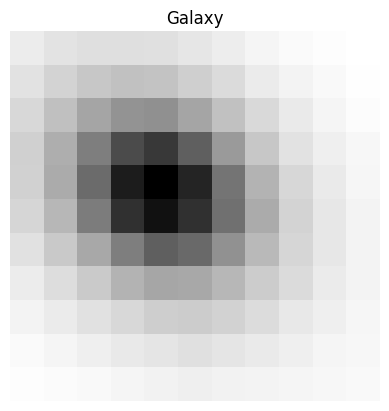

In [4]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs2[:,:,0,0].T,cmap=cm.gray, interpolation='nearest')

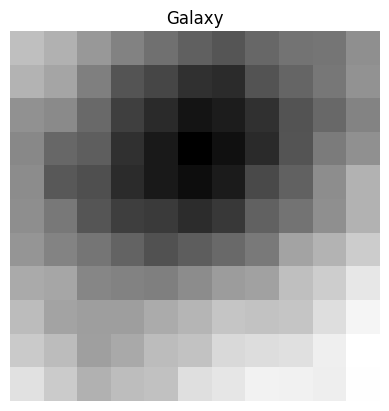

In [5]:
fg=df2['class'][df2['class']=='GALAXY']
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs2[:,:,0,fg.index[1]].T,cmap=cm.gray, interpolation='nearest')

It is visible that there is variation in galaxy shape. Now two stars. 

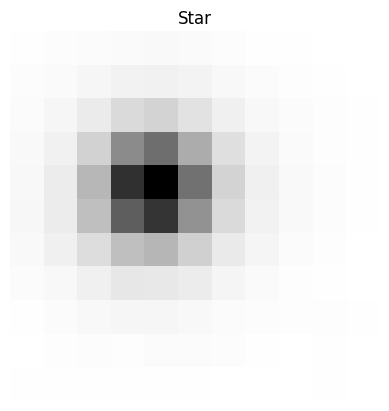

In [6]:
#finding star for display
fs=df2['class'][df2['class']=='STAR']
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs2[:,:,0,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

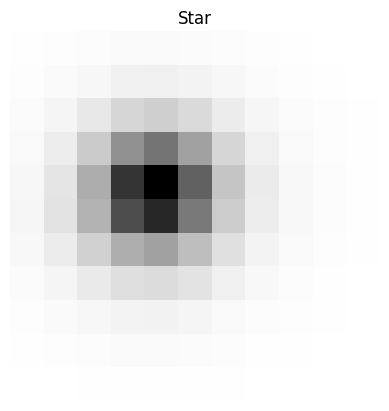

In [7]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs2[:,:,0,fs.index[1]].T,cmap=cm.gray, interpolation='nearest')

In contrast, different stars look very similar when scaled to their maxima. As it should be the galaxies are less concentrated than the stars. 

Because of the relevant noise in astronomical images I do not rescale the cut-out images, since rescaling can cause that noise level is very different between different images, while it should be rather similar in this data set.   

## Fit preparation

I use four different algorithms here. Two which do not use neural network, that are logisted regression and the tree based algorithm xgboost. In addition I use two neural networks: Firstly a fully connected multilayer network with several layers as perceptron. Secondly, a network which uses among others twodimensional convolutional layers, this network should be optimized for images. 

I now start with the setup tasks for the algorithm. Many are needed for the use of pytorch.
First I add the cpu. 

In [8]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


Next I add the image columns to the data frame as flattened columns. That is needed because all algorithms besides convolutional cannot work on images as input.  

In [9]:
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1
print(df2.columns)   

Index(['Unnamed: 0',      'index',      'objid',         'ra',        'dec',
         'psfMag_u',   'psfMag_g',   'psfMag_r',   'psfMag_i',   'psfMag_z',
       ...
                111,          112,          113,          114,          115,
                116,          117,          118,          119,          120],
      dtype='object', length=292)


/tmp/ipykernel_2543/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_2543/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_2543/1636207740.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

Next I split into test and train. 

In [10]:
#image_* are the feature for convoltional
# for other feature* are used 
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.50, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(25522, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [11]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create the data sets as needed for both neural network types. 

In [12]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())


Now I define the parameters needed for a first exploratory fit. 

In [13]:
NUM_FEATURES=121
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the the perceptron model plus the final parameters. 

In [14]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)

BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


This network has 3 layers before the output layer. 

## First fits

Now I run the fit. 

In [15]:
#data collected here
loss_stats_per = {
    'train': [], 'test': []
}
EPOCHS=20
LEARNING_RATE=0.001
torch_fit(model,train_loader,test_loader,EPOCHS,BATCH_SIZE,LEARNING_RATE,loss_stats_per)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.34925 | Test Loss: 0.21793
Epoch 002: | Train Loss: 0.22523 | Test Loss: 0.11473
Epoch 003: | Train Loss: 0.14119 | Test Loss: 0.09219
Epoch 004: | Train Loss: 0.07712 | Test Loss: 0.05599
Epoch 005: | Train Loss: 0.05964 | Test Loss: 0.04834
Epoch 006: | Train Loss: 0.05757 | Test Loss: 0.03902
Epoch 007: | Train Loss: 0.06859 | Test Loss: 0.03492
Epoch 008: | Train Loss: 0.03778 | Test Loss: 0.05834
Epoch 009: | Train Loss: 0.03202 | Test Loss: 0.04858
Epoch 010: | Train Loss: 0.04366 | Test Loss: 0.05038
Epoch 011: | Train Loss: 0.03336 | Test Loss: 0.06533
Epoch 012: | Train Loss: 0.02713 | Test Loss: 0.04076
Epoch 013: | Train Loss: 0.02938 | Test Loss: 0.06296
Epoch 014: | Train Loss: 0.05142 | Test Loss: 0.05280
Epoch 015: | Train Loss: 0.04258 | Test Loss: 0.08705
Epoch 016: | Train Loss: 0.05952 | Test Loss: 0.05103
Epoch 017: | Train Loss: 0.04617 | Test Loss: 0.09157
Epoch 018: | Train Loss: 0.05492 | Test Loss: 0.06730
Epoch 019: | Train Loss: 0.0

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

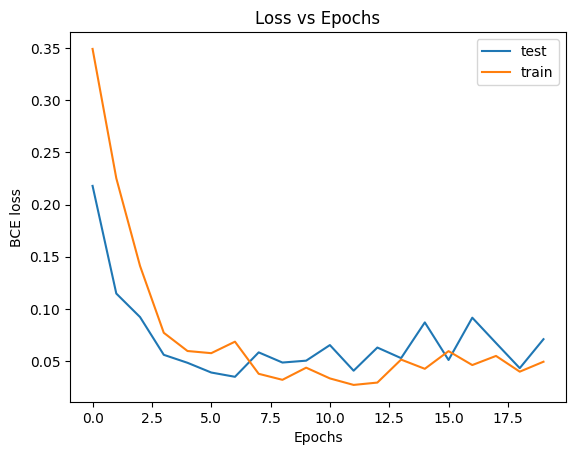

In [16]:

plt.plot(loss_stats_per['test'],label='test')
plt.plot(loss_stats_per['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

The loss clearly improves overall for test and train with some variation showing that it is not robust. The number of iteration here is likely not enough as expected in a first exploration. Since the loss is smaller in test there is likely overfitting. 

Now to the convolutional algorithm. The data needs to be loaded separately because now the images are used. 

In [17]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

I now load the convolutional neural network. 

In [18]:
keep_prob=1
model2 =CNNBinary3(keep_prob)
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


This network two structures consisting of convolutional layers and pooling which consider the image structures, then one multiconnected and finally a later to get the single probablity as output. 

Now define the dictionary for data collection and then fit the data. 

In [19]:
loss_stats_conv = {
    'train': [], 'test': []
}
EPOCHS=20
BATCH_SIZE=32
LEARNING_RATE=0.001
torch_fit(model2,train_im_loader,test_im_loader,EPOCHS,BATCH_SIZE,LEARNING_RATE,loss_stats_conv)

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 33.12756 | Test Loss: 33.65984
Epoch 002: | Train Loss: 33.12448 | Test Loss: 33.65984
Epoch 003: | Train Loss: 33.13057 | Test Loss: 33.65984
Epoch 004: | Train Loss: 33.13057 | Test Loss: 33.65984
Epoch 005: | Train Loss: 33.12448 | Test Loss: 33.65984
Epoch 006: | Train Loss: 33.12448 | Test Loss: 33.65984
Epoch 007: | Train Loss: 33.12143 | Test Loss: 33.65984
Epoch 008: | Train Loss: 33.12752 | Test Loss: 33.65984
Epoch 009: | Train Loss: 33.12143 | Test Loss: 33.65984
Epoch 010: | Train Loss: 33.12448 | Test Loss: 33.65984
Epoch 011: | Train Loss: 33.12143 | Test Loss: 33.65984
Epoch 012: | Train Loss: 33.12752 | Test Loss: 33.65984
Epoch 013: | Train Loss: 33.13362 | Test Loss: 33.65984
Epoch 014: | Train Loss: 33.13362 | Test Loss: 33.65984
Epoch 015: | Train Loss: 33.12752 | Test Loss: 33.65984
Epoch 016: | Train Loss: 33.12448 | Test Loss: 33.65984
Epoch 017: | Train Loss: 33.13666 | Test Loss: 33.65984
Epoch 018: | Train Loss: 33.12448 | Test Loss: 3

Below I plot both neural network results. 

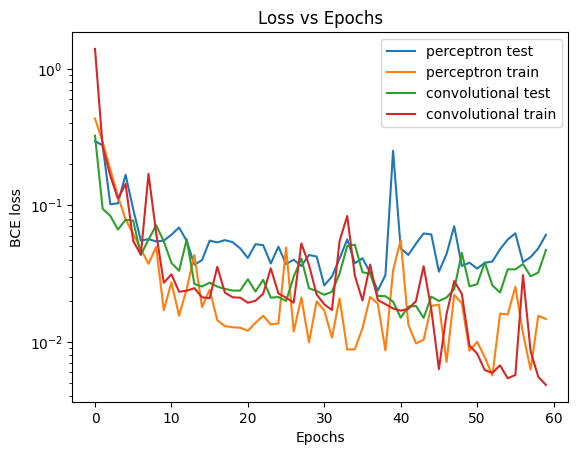

In [25]:
plt.plot(loss_stats_per['test'],label='perceptron test')
plt.plot(loss_stats_per['train'],label='perceptron train')
plt.plot(loss_stats_conv['test'],label='convolutional test')
plt.plot(loss_stats_conv['train'],label='convolutional train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.yscale("log")
#plt.ylim(0,2)


Convolutional looks better, but there is overfitting, the final loss is not the best. 

Now I do some other algorithms with standard settings. First xgboost. 

In [20]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

Now logistic regression. 

In [21]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=6000,penalty='none').fit(feature_train,target_train)

Now I predict results and get confusing matrixes. 

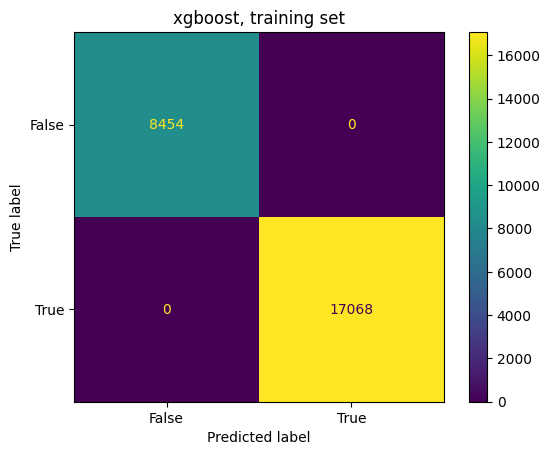

In [22]:
x_pred_train=xc1.predict(feature_train)
x_pred_test=xc1.predict(feature_test)
x_pred_prob_train=xc1.predict_proba(feature_train)
x_pred_prob_test=xc1.predict_proba(feature_test)
x_conf_train = confusion_matrix(target_train, np.round(x_pred_train), labels=xc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_train,
                               display_labels=xc1.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

In the training set the classfication is perfect, indicating likely overfitting.


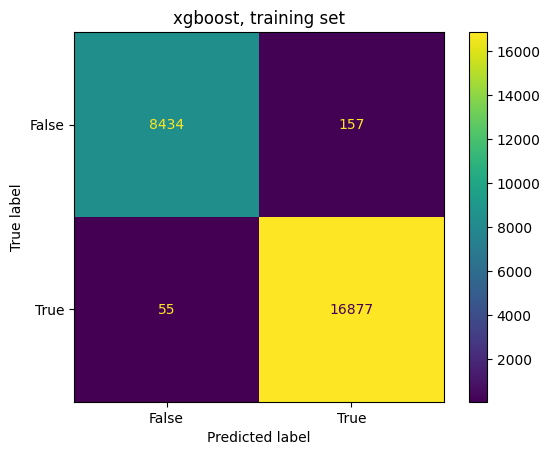

In [23]:
x_conf_test = confusion_matrix(target_test, np.round(x_pred_test), labels=xc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_test,
                               display_labels=xc1.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

Here 44/16 are missiclasfied confirming that there is over fitting.

Now logistic regression. 

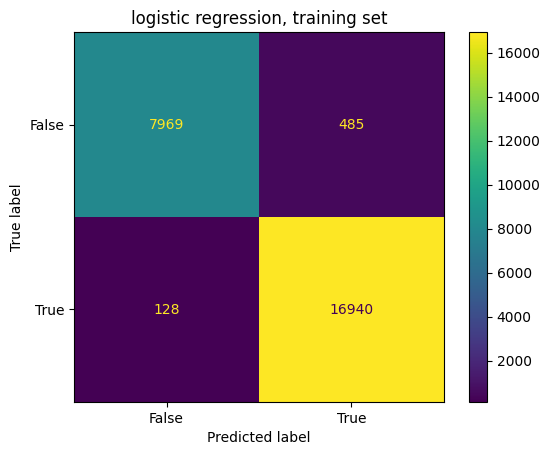

In [24]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, np.round(l_train_pred), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"logistic regression, training set")
plt.show()

For using 4 sets not anymore perfect classification here.  Worse with 10. 

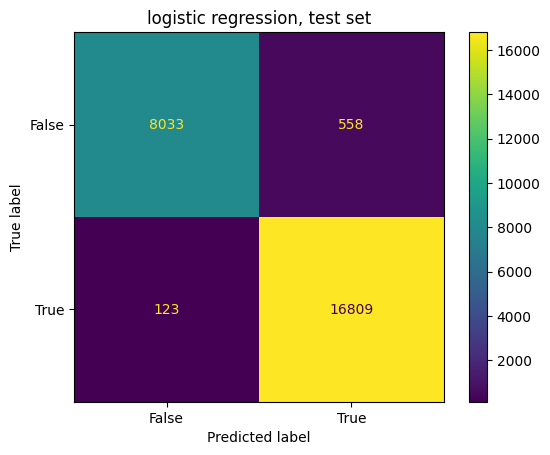

In [25]:
l_conf_test = confusion_matrix(target_test, np.round(l_test_pred), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"logistic regression, test set")
plt.show()

Now also clearly mpre missclassified in test than for xgboost. Nearly no overfitting for logistic regression.

Now prediction for neural network. 

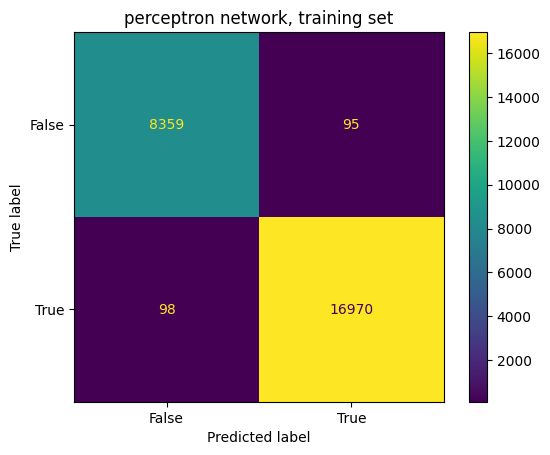

In [26]:
p_pred_test=pred_torch(model,test_loader)
p_pred_train=pred_torch(model,train_loader_pred)
p_conf_train = confusion_matrix(target_train, np.round(p_pred_train), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=p_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"perceptron network, training set")
plt.show()

Here the classification is not perfect in training. Possible the fit is not yet converged. Howver, it is still small compared to the total numbers.

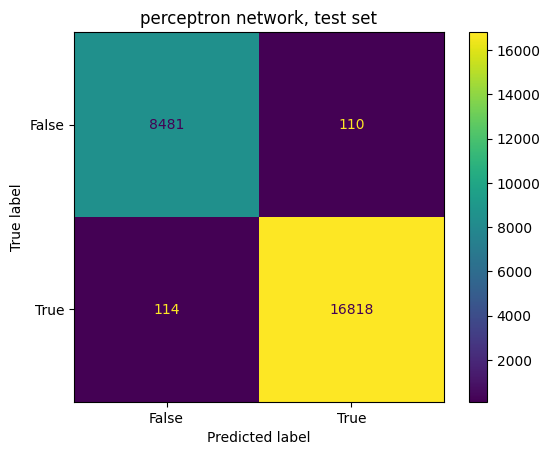

In [27]:
p_conf_test = confusion_matrix(target_test, np.round(p_pred_test), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=p_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"perceptron network, test set")
plt.show()

In test it is better than xgboost not my a big a big factor but clearly.

Now convolutional network. 

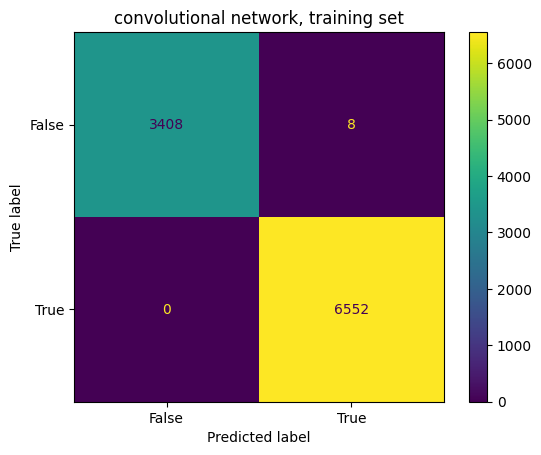

In [36]:
c_pred_test=pred_torch(model2,test_im_loader)
c_pred_train=pred_torch(model2,train_im_loader_pred)
c_conf_train = confusion_matrix(target_train, np.round(c_pred_train), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_train,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"convolutional network, training set")
plt.show()

This is nearly perfect in train, which is likely overfitting. Again checking with test. 

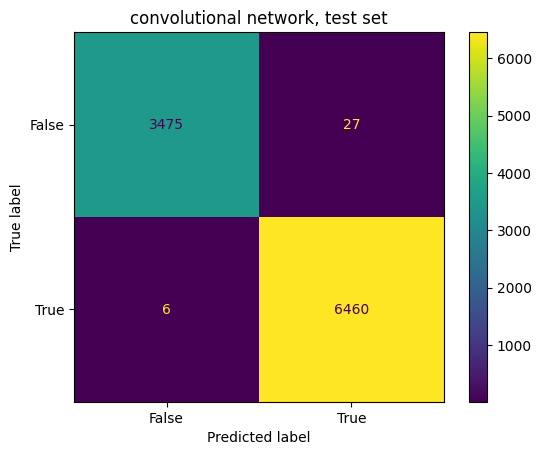

In [37]:
c_conf_test = confusion_matrix(target_test, np.round(c_pred_test), labels=lc1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_test,
                               display_labels=lc1.classes_)
disp.plot()
plt.title(f"convolutional network, test set")
plt.show()

This is slightly better than the perecptron, thus it is the best method, but the differences are small for the data size. 

Now I am calculating f1-scores for all. 

In [38]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,x_pred_train),5)}")
print(f"xgboost test {np.round(f1_score(target_test,x_pred_test),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(p_pred_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(p_pred_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_pred_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_pred_test)),5)}")

F1-scores
Logistic train 0.99276
Logistic test 0.98814
xgboost train 1.0
xgboost test 0.99537
perceptron train 0.99901
perceptron test 0.99691
conv2d train 0.99939
conv2d test 0.99745


All rather good, the differences are small. In test convolutional network is best, then xgboost, then preceptron, then logistic regression.
Always test is worse than train, such there is overfitting. 

As strategy against it I use l2 regularization because that is possible for all algorithms. 

I  now run  convolutional network for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [ ]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
#here a small regulrization is done for speed
n_it=200
#add more lower regularizations? seem needed and plausible when more data is added 
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,n_it,64,0.001,regs)
np.savetxt("conv2d_reg1_"+str(n_it)+"_10sets.txt",conv2d_stats)
#loading past run with more iterations
con2d_stats=np.loadtxt("conv2d_reg1_200_10sets.txt")

running reg of 1e-06
Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.62797 | Test Loss: 0.15239
Epoch 002: | Train Loss: 0.21166 | Test Loss: 0.09352
Epoch 003: | Train Loss: 0.16579 | Test Loss: 0.09609
Epoch 004: | Train Loss: 0.06640 | Test Loss: 0.04835
Epoch 005: | Train Loss: 0.06704 | Test Loss: 0.06392
Epoch 006: | Train Loss: 0.05650 | Test Loss: 0.05087
Epoch 007: | Train Loss: 0.04785 | Test Loss: 0.05705
Epoch 008: | Train Loss: 0.04784 | Test Loss: 0.04912
Epoch 009: | Train Loss: 0.04411 | Test Loss: 0.05252
Epoch 010: | Train Loss: 0.04457 | Test Loss: 0.04598
Epoch 011: | Train Loss: 0.04605 | Test Loss: 0.05011
Epoch 012: | Train Loss: 0.04184 | Test Loss: 0.04707
Epoch 013: | Train Loss: 0.04422 | Test Loss: 0.04351
Epoch 014: | Train Loss: 0.05080 | Test Loss: 0.04402
Epoch 015: | Train Loss: 0.03469 | Test Loss: 0.05222
Epoch 016: | Train Loss: 0.03947 | Test Loss: 0.06258
Epoch 017: | Train Loss: 0.05338 | Test Loss: 0.04054
Epoch 018: | Train Loss: 0.04016 | Test Loss: 0.05018
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.01241 | Test Loss: 0.05155
Epoch 154: | Train Loss: 0.01486 | Test Loss: 0.04637
Epoch 155: | Train Loss: 0.00971 | Test Loss: 0.05893
Epoch 156: | Train Loss: 0.00362 | Test Loss: 0.07078
Epoch 157: | Train Loss: 0.03560 | Test Loss: 0.04574
Epoch 158: | Train Loss: 0.00743 | Test Loss: 0.04819
Epoch 159: | Train Loss: 0.00665 | Test Loss: 0.06400
Epoch 160: | Train Loss: 0.01563 | Test Loss: 0.09207
Epoch 161: | Train Loss: 0.01407 | Test Loss: 0.05223
Epoch 162: | Train Loss: 0.01252 | Test Loss: 0.06113
Epoch 163: | Train Loss: 0.00589 | Test Loss: 0.05677
Epoch 164: | Train Loss: 0.00513 | Test Loss: 0.07110
Epoch 165: | Train Loss: 0.02702 | Test Loss: 0.06221
Epoch 166: | Train Loss: 0.03732 | Test Loss: 0.08763
Epoch 167: | Train Loss: 0.01167 | Test Loss: 0.06395
Epoch 168: | Train Loss: 0.01307 | Test Loss: 0.08124
Epoch 169: | Train Loss: 0.00968 | Test Loss: 0.05344
Epoch 170: | Train Loss: 0.00702 | Test Loss: 0.07783
Epoch 171: | Train Loss: 0.0

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.52377 | Test Loss: 3.03287
Epoch 002: | Train Loss: 0.23591 | Test Loss: 0.11177
Epoch 003: | Train Loss: 0.19614 | Test Loss: 0.16549
Epoch 004: | Train Loss: 0.07234 | Test Loss: 0.05839
Epoch 005: | Train Loss: 0.04466 | Test Loss: 0.06024
Epoch 006: | Train Loss: 0.05535 | Test Loss: 0.06170
Epoch 007: | Train Loss: 0.05762 | Test Loss: 1.20076
Epoch 008: | Train Loss: 0.05774 | Test Loss: 0.04361
Epoch 009: | Train Loss: 0.03196 | Test Loss: 0.05352
Epoch 010: | Train Loss: 0.03012 | Test Loss: 0.04618
Epoch 011: | Train Loss: 0.02443 | Test Loss: 0.04468
Epoch 012: | Train Loss: 0.02729 | Test Loss: 0.04722
Epoch 013: | Train Loss: 0.02682 | Test Loss: 0.05181
Epoch 014: | Train Loss: 0.04939 | Test Loss: 0.04511
Epoch 015: | Train Loss: 0.02487 | Test Loss: 0.03809
Epoch 016: | Train Loss: 0.03605 | Test Loss: 0.05229
Epoch 017: | Train Loss: 0.02483 | Test Loss: 0.05195
Epoch 018: | Train Loss: 0.02105 | Test Loss: 0.04783
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00505 | Test Loss: 0.04947
Epoch 154: | Train Loss: 0.01566 | Test Loss: 0.05507
Epoch 155: | Train Loss: 0.01959 | Test Loss: 0.04401
Epoch 156: | Train Loss: 0.01036 | Test Loss: 0.03956
Epoch 157: | Train Loss: 0.00372 | Test Loss: 0.04424
Epoch 158: | Train Loss: 0.00609 | Test Loss: 0.04810
Epoch 159: | Train Loss: 0.00231 | Test Loss: 0.06230
Epoch 160: | Train Loss: 0.00755 | Test Loss: 0.05066
Epoch 161: | Train Loss: 0.00710 | Test Loss: 0.07547
Epoch 162: | Train Loss: 0.00863 | Test Loss: 0.05380
Epoch 163: | Train Loss: 0.02643 | Test Loss: 0.03835
Epoch 164: | Train Loss: 0.00928 | Test Loss: 0.03611
Epoch 165: | Train Loss: 0.01283 | Test Loss: 0.04309
Epoch 166: | Train Loss: 0.01606 | Test Loss: 0.05012
Epoch 167: | Train Loss: 0.00976 | Test Loss: 0.06804
Epoch 168: | Train Loss: 0.00972 | Test Loss: 0.04132
Epoch 169: | Train Loss: 0.01230 | Test Loss: 0.08334
Epoch 170: | Train Loss: 0.00981 | Test Loss: 0.04198
Epoch 171: | Train Loss: 0.0

/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.90782 | Test Loss: 0.13053
Epoch 002: | Train Loss: 0.11513 | Test Loss: 0.07626
Epoch 003: | Train Loss: 0.08873 | Test Loss: 0.05901
Epoch 004: | Train Loss: 0.04665 | Test Loss: 0.07056
Epoch 005: | Train Loss: 0.04184 | Test Loss: 0.05402
Epoch 006: | Train Loss: 0.08623 | Test Loss: 0.06589
Epoch 007: | Train Loss: 0.03624 | Test Loss: 0.04194
Epoch 008: | Train Loss: 0.02572 | Test Loss: 0.03666
Epoch 009: | Train Loss: 0.03375 | Test Loss: 0.05295
Epoch 010: | Train Loss: 0.02900 | Test Loss: 0.04731
Epoch 011: | Train Loss: 0.03232 | Test Loss: 0.04299
Epoch 012: | Train Loss: 0.02278 | Test Loss: 0.03578
Epoch 013: | Train Loss: 0.02019 | Test Loss: 0.02986
Epoch 014: | Train Loss: 0.04258 | Test Loss: 0.03526
Epoch 015: | Train Loss: 0.02509 | Test Loss: 0.02958
Epoch 016: | Train Loss: 0.02339 | Test Loss: 0.03036
Epoch 017: | Train Loss: 0.01781 | Test Loss: 0.03368
Epoch 018: | Train Loss: 0.01964 | Test Loss: 0.03041
Epoch 019: | Train Loss: 0.0

Now running also the multi layer perceptron with different regularizations.

In [ ]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
n_it=200
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,n_it,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_"+str(n_it)+"_4sets.txt",per_stats)
per_stats=np.loadtxt("per_reg1_200_4sets.txt")

running reg of 1e-06
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.33542 | Test Loss: 0.19681
Epoch 002: | Train Loss: 0.18462 | Test Loss: 0.12441
Epoch 003: | Train Loss: 0.15939 | Test Loss: 0.11797
Epoch 004: | Train Loss: 0.09156 | Test Loss: 0.07647
Epoch 005: | Train Loss: 0.04663 | Test Loss: 0.06655
Epoch 006: | Train Loss: 0.05670 | Test Loss: 0.04418
Epoch 007: | Train Loss: 0.03930 | Test Loss: 0.05668
Epoch 008: | Train Loss: 0.05856 | Test Loss: 0.08582
Epoch 009: | Train Loss: 0.05347 | Test Loss: 0.04002
Epoch 010: | Train Loss: 0.05993 | Test Loss: 0.06488
Epoch 011: | Train Loss: 0.02026 | Test Loss: 0.06951
Epoch 012: | Train Loss: 0.01778 | Test Loss: 0.05321
Epoch 013: | Train Loss: 0.01704 | Test Loss: 0.06350
Epoch 014: | Train Loss: 0.03869 | Test Loss: 0.03796
Epoch 015: | Train Loss: 0.01738 | Test Loss: 0.04852
Epoch 016: | Train Loss: 0.01758 | Test Loss: 0.05103
Epoch 017: | Train Loss: 0.01350 | Test Loss: 0.05136
Epoch 018: | Train Loss: 0.02989 | Test Loss: 0.04042
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00879 | Test Loss: 0.06915
Epoch 154: | Train Loss: 0.01744 | Test Loss: 0.06936
Epoch 155: | Train Loss: 0.01659 | Test Loss: 0.12789
Epoch 156: | Train Loss: 0.02694 | Test Loss: 0.07812
Epoch 157: | Train Loss: 0.02418 | Test Loss: 0.15886
Epoch 158: | Train Loss: 0.01698 | Test Loss: 0.10571
Epoch 159: | Train Loss: 0.06836 | Test Loss: 0.05610
Epoch 160: | Train Loss: 0.00659 | Test Loss: 0.06811
Epoch 161: | Train Loss: 0.01533 | Test Loss: 0.06716
Epoch 162: | Train Loss: 0.05906 | Test Loss: 0.32737
Epoch 163: | Train Loss: 0.11542 | Test Loss: 0.08152
Epoch 164: | Train Loss: 0.00597 | Test Loss: 0.09189
Epoch 165: | Train Loss: 0.01749 | Test Loss: 0.10839
Epoch 166: | Train Loss: 0.03355 | Test Loss: 0.06302
Epoch 167: | Train Loss: 0.00799 | Test Loss: 0.06893
Epoch 168: | Train Loss: 0.00792 | Test Loss: 0.06313
Epoch 169: | Train Loss: 0.00562 | Test Loss: 0.07589
Epoch 170: | Train Loss: 0.00675 | Test Loss: 0.09514
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.39360 | Test Loss: 0.44197
Epoch 002: | Train Loss: 0.24294 | Test Loss: 0.32496
Epoch 003: | Train Loss: 0.29600 | Test Loss: 0.20820
Epoch 004: | Train Loss: 0.18589 | Test Loss: 0.17213
Epoch 005: | Train Loss: 0.14357 | Test Loss: 0.11553
Epoch 006: | Train Loss: 0.26960 | Test Loss: 0.11060
Epoch 007: | Train Loss: 0.10496 | Test Loss: 0.11434
Epoch 008: | Train Loss: 0.10471 | Test Loss: 0.08170
Epoch 009: | Train Loss: 0.08250 | Test Loss: 0.13202
Epoch 010: | Train Loss: 0.06892 | Test Loss: 0.07084
Epoch 011: | Train Loss: 0.08604 | Test Loss: 0.11114
Epoch 012: | Train Loss: 0.07607 | Test Loss: 0.11164
Epoch 013: | Train Loss: 0.05702 | Test Loss: 0.04954
Epoch 014: | Train Loss: 0.02614 | Test Loss: 0.04483
Epoch 015: | Train Loss: 0.02256 | Test Loss: 0.05158
Epoch 016: | Train Loss: 0.02726 | Test Loss: 0.03321
Epoch 017: | Train Loss: 0.01336 | Test Loss: 0.04127
Epoch 018: | Train Loss: 0.02047 | Test Loss: 0.05162
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.02033 | Test Loss: 0.05814
Epoch 154: | Train Loss: 0.01746 | Test Loss: 0.05729
Epoch 155: | Train Loss: 0.01587 | Test Loss: 0.07347
Epoch 156: | Train Loss: 0.01896 | Test Loss: 0.04501
Epoch 157: | Train Loss: 0.01548 | Test Loss: 0.05612
Epoch 158: | Train Loss: 0.04536 | Test Loss: 0.05934
Epoch 159: | Train Loss: 0.01523 | Test Loss: 0.05585
Epoch 160: | Train Loss: 0.01526 | Test Loss: 0.06307
Epoch 161: | Train Loss: 0.05028 | Test Loss: 0.03766
Epoch 162: | Train Loss: 0.01495 | Test Loss: 0.05150
Epoch 163: | Train Loss: 0.01331 | Test Loss: 0.04950
Epoch 164: | Train Loss: 0.01263 | Test Loss: 0.06283
Epoch 165: | Train Loss: 0.05008 | Test Loss: 0.04083
Epoch 166: | Train Loss: 0.01597 | Test Loss: 0.05039
Epoch 167: | Train Loss: 0.00784 | Test Loss: 0.03455
Epoch 168: | Train Loss: 0.00377 | Test Loss: 0.06515
Epoch 169: | Train Loss: 0.00314 | Test Loss: 0.07266
Epoch 170: | Train Loss: 0.00520 | Test Loss: 0.05672
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43211 | Test Loss: 0.19542
Epoch 002: | Train Loss: 0.31268 | Test Loss: 0.25536
Epoch 003: | Train Loss: 0.22419 | Test Loss: 0.13196
Epoch 004: | Train Loss: 0.15569 | Test Loss: 0.07935
Epoch 005: | Train Loss: 0.15117 | Test Loss: 0.09957
Epoch 006: | Train Loss: 0.10544 | Test Loss: 0.04867
Epoch 007: | Train Loss: 0.07163 | Test Loss: 0.03712
Epoch 008: | Train Loss: 0.07844 | Test Loss: 0.05722
Epoch 009: | Train Loss: 0.05369 | Test Loss: 0.03353
Epoch 010: | Train Loss: 0.02872 | Test Loss: 0.05362
Epoch 011: | Train Loss: 0.02921 | Test Loss: 0.04205
Epoch 012: | Train Loss: 0.04001 | Test Loss: 0.03422
Epoch 013: | Train Loss: 0.01694 | Test Loss: 0.04045
Epoch 014: | Train Loss: 0.02487 | Test Loss: 0.03600
Epoch 015: | Train Loss: 0.02397 | Test Loss: 0.03033
Epoch 016: | Train Loss: 0.02153 | Test Loss: 0.03385
Epoch 017: | Train Loss: 0.02254 | Test Loss: 0.02749
Epoch 018: | Train Loss: 0.02323 | Test Loss: 0.02354
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.02947 | Test Loss: 0.04600
Epoch 154: | Train Loss: 0.01547 | Test Loss: 0.05560
Epoch 155: | Train Loss: 0.00480 | Test Loss: 0.07605
Epoch 156: | Train Loss: 0.02450 | Test Loss: 0.07031
Epoch 157: | Train Loss: 0.01816 | Test Loss: 0.07117
Epoch 158: | Train Loss: 0.01696 | Test Loss: 0.05950
Epoch 159: | Train Loss: 0.00573 | Test Loss: 0.07004
Epoch 160: | Train Loss: 0.01364 | Test Loss: 0.06390


Now also adding regularization to xgboost.

In [39]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
np.savetxt("xgboost_4sets_star_galaxies.txt",stats_xgb)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000


Now also adding logistic regression with l2 regularization. 

In [40]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
#adding max_its =x at the end 10000 is default but was still o.k. here 
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
np.savetxt("logistic_4sets_star_galaxies.txt",stats_log)

doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100


Below I plot the F1 score for all. 

not regularized
Logistic train 0.99276
Logistic test 0.98814
xgboost train 1.0
xgboost test 0.99537
perceptron train 0.99901
perceptron test 0.99691
convolutional train 0.99939
convolutional test 0.99745
best regularized
xgboost train 1.0
xgboost test 0.99568
logistic train 0.99307
logistic test 0.98922
perceptron train 0.99802
perceptron test 0.99606
convolutional train 0.99939
convolutional test 0.99807


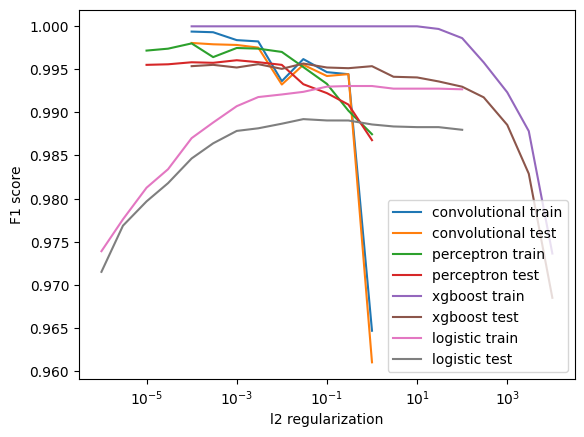

In [50]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='convolutional train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='convolutional test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,x_pred_train),5)}")
print(f"xgboost test {np.round(f1_score(target_test,x_pred_test),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(p_pred_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(p_pred_test)),5)}")
print(f"convolutional train {np.round(f1_score(target_train,np.round(c_pred_train)),5)}")
print(f"convolutional test {np.round(f1_score(target_test,np.round(c_pred_test)),5)}")
print("best regularized")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")
print(f"logistic train {np.round(np.max(stats_log[1]),5)}")
print(f"logistic test {np.round(np.max(stats_log[2]),5)}")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"convolutional train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"convolutional test {np.round(np.max(conv2d_stats[2]),5)}")

Is improved now in test for all besides xgboost for its stays constant. Best is convolutional network, then perceptron, then on the same level logistic and xgboost. There are so few wrong, that it can be partlz chnace. Log loss depends less on stat statistic, thus I also look on this measure now. 

not regularized
Logistic train 0.02833
Logistic test 0.13177
xgboost train 0.00064
xgboost test 0.02459
perceptron train 0.00704
perceptron test 0.03457
convolutional train 0.0041
convolutional test 0.02653
best regularized
xgboost train 0.00044
xgboost test 0.02277
logistic train 0.02833
logistic test 0.10469
perceptron train 0.01014
perceptron test 0.02888
convolutional train 0.00362
convolutional test 0.01083


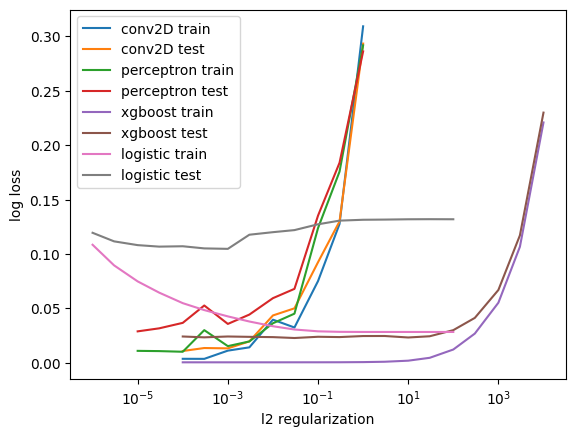

In [51]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,x_pred_prob_train),5)}")
print(f"xgboost test {np.round(log_loss(target_test,x_pred_prob_test),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(p_pred_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(p_pred_test)),5)}")
print(f"convolutional train {np.round(log_loss(target_train,(c_pred_train)),5)}")
print(f"convolutional test {np.round(log_loss(target_test,(c_pred_test)),5)}")
print("best regularized")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")
print(f"logistic train {np.round(np.min(stats_log[3]),5)}")
print(f"logistic test {np.round(np.min(stats_log[4]),5)}")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"convolutional train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"convolutional test {np.round(np.min(conv2d_stats[4]),5)}")

Similar but not identical. Best is convoltional network, then xgboost, then logistic then perceptron, all achioeve rather values.

## Final fits

As the next step I run the best of all four algorithm. I decide to use log loss as to find the best one. 


First I print the values.

In [84]:
best_reg_conv=conv2d_stats[0,int(np.argmin(conv2d_stats[4,0:]))]
print(f"best regularization of convolutional is {best_reg_conv}")
best_reg_per=per_stats[0,(np.argmin(per_stats[4]))]
print(f"best regularization of perceptron is {best_reg_per}")
best_reg_xgb=stats_xgb[0,(np.argmin(stats_xgb[4]))]
print(f"best regularization of xgboost is {best_reg_xgb}")
best_reg_log=stats_log[0,(np.argmin(stats_log[4]))]
print(f"best regularization of logistic is {best_reg_log}")

best regularization of convolutional is 0.0003
best regularization of perceptron is 0.03
best regularization of xgboost is 3.0
best regularization of logistic is 0.0003


In [85]:
xc2=XGBClassifier(max_depth=6,reg_lambda=3.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

In [86]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

In [80]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.03)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.38840 | Test Loss: 0.17213
Epoch 002: | Train Loss: 0.27422 | Test Loss: 0.27228
Epoch 003: | Train Loss: 0.29803 | Test Loss: 0.18071
Epoch 004: | Train Loss: 0.32367 | Test Loss: 0.25876
Epoch 005: | Train Loss: 0.29180 | Test Loss: 0.25983
Epoch 006: | Train Loss: 0.31184 | Test Loss: 0.25652
Epoch 007: | Train Loss: 0.28726 | Test Loss: 0.25025
Epoch 008: | Train Loss: 0.28421 | Test Loss: 0.26624
Epoch 009: | Train Loss: 0.32578 | Test Loss: 0.25650
Epoch 010: | Train Loss: 0.32512 | Test Loss: 0.25564
Epoch 011: | Train Loss: 0.31148 | Test Loss: 0.24919
Epoch 012: | Train Loss: 0.26411 | Test Loss: 0.19570
Epoch 013: | Train Loss: 0.30909 | Test Loss: 0.24582
Epoch 014: | Train Loss: 0.31838 | Test Loss: 0.25286
Epoch 015: | Train Loss: 0.30524 | Test Loss: 0.11984
Epoch 016: | Train Loss: 0.30872 | Test Loss: 0.12391
Epoch 017: | Train Loss: 0.28346 | Test Loss: 0.18588
Epoch 018: | Train Loss: 0.31051 | Test Loss: 0.12952
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.12220 | Test Loss: 0.16372
Epoch 154: | Train Loss: 0.04721 | Test Loss: 0.15947
Epoch 155: | Train Loss: 0.05000 | Test Loss: 0.16775
Epoch 156: | Train Loss: 0.06205 | Test Loss: 0.16350
Epoch 157: | Train Loss: 0.04415 | Test Loss: 0.23424
Epoch 158: | Train Loss: 0.05289 | Test Loss: 0.09459
Epoch 159: | Train Loss: 0.04726 | Test Loss: 0.09088
Epoch 160: | Train Loss: 0.04254 | Test Loss: 0.08995
Epoch 161: | Train Loss: 0.04203 | Test Loss: 0.09135
Epoch 162: | Train Loss: 0.05718 | Test Loss: 0.11296
Epoch 163: | Train Loss: 0.04577 | Test Loss: 0.09083
Epoch 164: | Train Loss: 0.04291 | Test Loss: 0.16418
Epoch 165: | Train Loss: 0.04238 | Test Loss: 0.10183
Epoch 166: | Train Loss: 0.04902 | Test Loss: 0.09528
Epoch 167: | Train Loss: 0.04306 | Test Loss: 0.10123
Epoch 168: | Train Loss: 0.04253 | Test Loss: 0.09400
Epoch 169: | Train Loss: 0.04407 | Test Loss: 0.06702
Epoch 170: | Train Loss: 0.04924 | Test Loss: 0.05472
Epoch 171: | Train Loss: 0.0

In [87]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3(keep_prob)            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.0003)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/home/tobias/ml-testing/astr-images/functions_ml.py:133: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.32644 | Test Loss: 0.26636
Epoch 002: | Train Loss: 0.63149 | Test Loss: 0.32212
Epoch 003: | Train Loss: 0.32177 | Test Loss: 1.10056
Epoch 004: | Train Loss: 0.34294 | Test Loss: 0.17476
Epoch 005: | Train Loss: 0.85283 | Test Loss: 0.25036
Epoch 006: | Train Loss: 0.70979 | Test Loss: 0.77903
Epoch 007: | Train Loss: 0.17410 | Test Loss: 0.24201
Epoch 008: | Train Loss: 0.06484 | Test Loss: 0.16649
Epoch 009: | Train Loss: 0.04920 | Test Loss: 0.31028
Epoch 010: | Train Loss: 0.04605 | Test Loss: 0.17328
Epoch 011: | Train Loss: 0.01125 | Test Loss: 0.09842
Epoch 012: | Train Loss: 0.04254 | Test Loss: 0.04151
Epoch 013: | Train Loss: 0.06042 | Test Loss: 0.04394
Epoch 014: | Train Loss: 0.01305 | Test Loss: 0.03735
Epoch 015: | Train Loss: 0.01259 | Test Loss: 0.03499
Epoch 016: | Train Loss: 0.01215 | Test Loss: 0.03247
Epoch 017: | Train Loss: 0.01103 | Test Loss: 0.02796
Epoch 018: | Train Loss: 0.01949 | Test Loss: 0.02438
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00101 | Test Loss: 0.08132
Epoch 154: | Train Loss: 0.00120 | Test Loss: 0.09073
Epoch 155: | Train Loss: 0.00146 | Test Loss: 0.08852
Epoch 156: | Train Loss: 0.00103 | Test Loss: 0.04362
Epoch 157: | Train Loss: 0.00228 | Test Loss: 0.04594
Epoch 158: | Train Loss: 0.00134 | Test Loss: 0.15533
Epoch 159: | Train Loss: 0.00098 | Test Loss: 0.09103
Epoch 160: | Train Loss: 0.00589 | Test Loss: 0.07045
Epoch 161: | Train Loss: 0.01041 | Test Loss: 0.07977
Epoch 162: | Train Loss: 0.00206 | Test Loss: 0.07914
Epoch 163: | Train Loss: 0.00191 | Test Loss: 0.08135
Epoch 164: | Train Loss: 0.00139 | Test Loss: 0.07910
Epoch 165: | Train Loss: 0.00103 | Test Loss: 0.09206
Epoch 166: | Train Loss: 0.00076 | Test Loss: 0.09286
Epoch 167: | Train Loss: 0.00077 | Test Loss: 0.09002
Epoch 168: | Train Loss: 0.00069 | Test Loss: 0.09583
Epoch 169: | Train Loss: 0.00088 | Test Loss: 0.08831
Epoch 170: | Train Loss: 0.00049 | Test Loss: 0.08450
Epoch 171: | Train Loss: 0.0

Now I am looking on wrong classifications concentrating on the ones which are clealy wrong. I print out the difference betwene model magnitude and star magnitude because that is around 0 for stars. 

In [89]:
c=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i]+l2_test_pred_prob[i,1])/4
    p=np.array([l2_test_pred_prob[i,1],x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.5:
        print(f"case {i} class is {df_test['class'].iat[i]} with p(galaxy) {np.round(p,3)}")
        print(f"Mag(model)-Mag(star)={np.round(df_test.modelMag_r.iat[i]-df_test.psfMag_r.iat[i],3)}")
        if df_test['class'].iat[i]=='GALAXY':
            print(f"redshift is {np.round(df_test.redshift.iat[i],4)}")
        else:
            print(f"velocity is {np.round(df_test.redshift.iat[i]*299792)}")
        c+=1
print(c)        
diff2=df2[df2['class']=='GALAXY'].modelMag_r-df2[df2['class']=='GALAXY'].psfMag_r
print(diff2.describe())

case 22 class is GALAXY with p(galaxy) [0.305 0.028 0.124 0.15 ]
Mag(model)-Mag(star)=-0.234
redshift is 0.4016
case 239 class is GALAXY with p(galaxy) [0.296 0.224 0.384 1.   ]
Mag(model)-Mag(star)=-0.312
redshift is 0.1316
case 915 class is STAR with p(galaxy) [0.553 0.087 0.828 0.819]
Mag(model)-Mag(star)=-0.023
velocity is 117.0
case 1092 class is GALAXY with p(galaxy) [0.006 0.277 0.762 0.   ]
Mag(model)-Mag(star)=-0.294
redshift is 0.1381
case 1131 class is STAR with p(galaxy) [1.    0.624 0.553 1.   ]
Mag(model)-Mag(star)=-0.001
velocity is -26.0
case 1289 class is GALAXY with p(galaxy) [0.044 0.052 0.058 0.   ]
Mag(model)-Mag(star)=-0.21
redshift is 0.5941
6
count    3092.000000
mean       -1.374348
std         0.633466
min        -6.088180
25%        -1.676228
50%        -1.268105
75%        -0.932505
max        -0.176110
dtype: float64


Looking on the properties of table, I have not yet found something obvious which hints that input classifications are faulty. The galaxies included here are more compact than most, that is expected that the galaxies with the problems are the compact ones, but that is true for both wrong classifications in the labels and by the algorithms. They are not obvious outliers, see plot below. Likely the sample is too small to be able to distinguish the options. 

(0.1, -1.0)

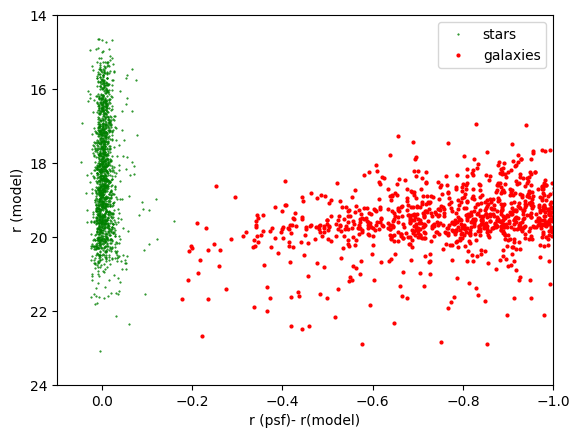

In [136]:
plt.plot(df2['modelMag_r'][df2['class']=='STAR']-df2['psfMag_r'][df2['class']=='STAR'],df2['modelMag_r'][df2['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.plot(df2['modelMag_r'][df2['class']=='GALAXY']-df2['psfMag_r'][df2['class']=='GALAXY'],df2['modelMag_r'][df2['class']=='GALAXY'],'o',ms=2,color='red',label='galaxies') 
plt.legend(loc="best")
plt.xlabel("r (psf)- r(model)")
plt.ylabel("r (model)")
plt.ylim(24,14)
plt.xlim(0.1,-1)
#plt.yscale("log")

Below I plot the images of the objects with classfications problems. 

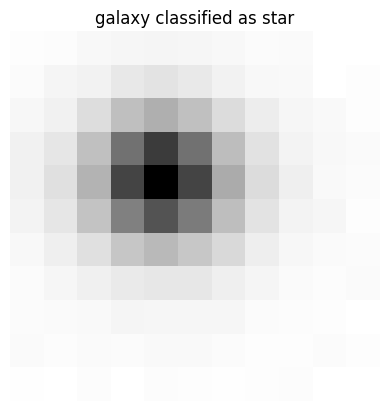

In [90]:
#all methods agree 
plt.axis('off')
plt.title("galaxy classified as star")
plt.imshow(-image_test[22,0,:,:].T,cmap=cm.gray, interpolation='nearest')

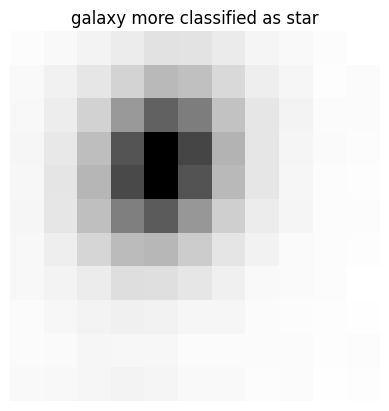

In [91]:
#convolutional different
plt.axis('off')
plt.title("galaxy more classified as star")
plt.imshow(-image_test[239,0,:,:].T,cmap=cm.gray, interpolation='nearest')

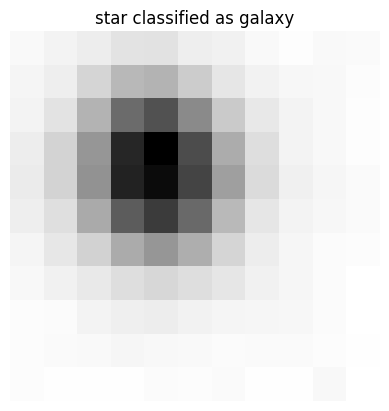

In [92]:
#xgboost disgarees 
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[915,0,:,:].T,cmap=cm.gray, interpolation='nearest')

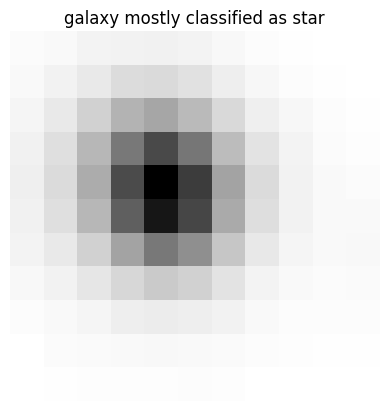

In [93]:
#perceptron is different from other methods
plt.axis('off')
plt.title("galaxy mostly classified as star")
plt.imshow(-image_test[1092,0,:,:].T,cmap=cm.gray, interpolation='nearest')

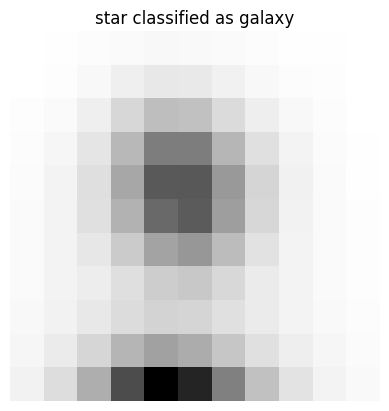

In [94]:
#all agree
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[1131,0,:,:].T,cmap=cm.gray, interpolation='nearest')

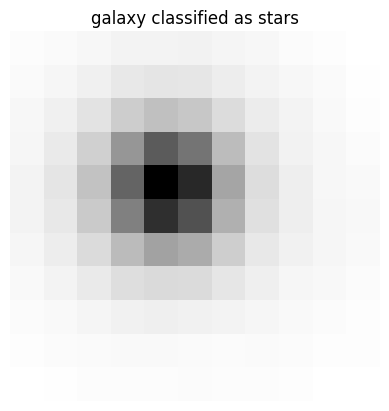

In [96]:
#all agree
plt.axis('off')
plt.title("galaxy classified as stars")
plt.imshow(-image_test[1289,0,:,:].T,cmap=cm.gray, interpolation='nearest')

The one above all look rather normal compact, there few if at all obvious galaxies to the eye.
All of those look rather round per eye and when there are differences it is in the level of concentration. The human eye is not particularly good in finding that. Thus looking on the images does not help. Algorithm are better. 

## Conclusions

It is rather to get a good classfication into star and galaxies, even simple methods like logistic achive very good results. None it is perfect, the reason for that is not clear, there are no clear problems with input classifications. Using more data likely helps to solve this problem.
For this prob;em it also would makes to look on others methods because the star class is very homogenous outlier detection methods are possible better. Also looking on shape based parameters like moments could be useful. 
That also simpler algorithms work well shows not unexpected that is not the best use case for neural networks. Still, they are also work. 